# Setup
This Jupyter Notebook is meant to be executed directly from Google Colab in a plug and play manner.
To enable this, the following code below can be run to set up the notebook

In [1]:
import os
import sys

!git clone -b gtzan_testing https://github.com/terryluan12/Genrify.git
!cd Genrify && make

sys.path.insert(0, "Genrify/src")

Cloning into 'Genrify'...
remote: Enumerating objects: 1087, done.
remote: Counting objects: 100% (476/476), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 1087 (delta 303), reused 390 (delta 262), pack-reused 611
Receiving objects: 100% (1087/1087), 8.63 MiB | 14.34 MiB/s, done.
Resolving deltas: 100% (692/692), done.
pip install -r requirements.txt
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=d05d27558bc0e44fc654ab75ccb32d39501d74fb011969e573f49daf8736db7b
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


Run code below if using Google Drive for retrieving test data and CNN models for the Ensemble model

In [2]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Preprocessing Code
The following code can be run to download the datasets and preprocess the datasets

In [3]:
from datasources import download_datasets, convert_files
from preprocessing import preprocess
from cnn.testhandler.TestHandler import TestHandler

In [4]:
# Make sure to change subset_num to the subset which you are using
subset_num = None # not used for testing data
#Possible method values:
#"spec", "mel", "chroma", "mfcc" to retrieve exclusive training datasets
#"create_testing_data" to create testing data for the first time (not needed anymore due to option below)
#"test" to unzip already preprocessed testing data from Google Drive
wavTomp3Towav = False  #if testing out converting gtzan from wav to mp3 back to wav
methods = ["spec", "mel", "chroma", "mfcc"]
download_datasets("Genrify/src")
for method in methods:
    preprocess(subset_num, method, "Genrify/src")

test_handler = TestHandler(batch_size=1, num_workers=1)

In [ ]:
import ensemble
from ensemble.ensemble import full_model
weak_learners=ensemble.get_weak_learners()
print("Test Accuracy:", full_model([test_handler.spec_test_loader,test_handler.mfcc_test_loader,test_handler.chroma_test_loader,test_handler.mel_test_loader], weak_learners=[weak_learners[x] for x in [0,1,2,3]], cuda=True))

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
classes = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
confusion_matrix = np.loadtxt("/content/Genrify/src/datasources/full_model_confusion_matirx.csv")
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Demo

Let's gather all of the test data together. Then take a closer look at the first sample. The test data came from [Free Music Archive](https://freemusicarchive.org/)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio, display
from torchvision.datasets import DatasetFolder
%matplotlib inline

In [ ]:
data_dir = "/content/Genrify/src/datasources/processed_test_data"
classes = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
full_dataset=DatasetFolder(data_dir, librosa.load, extensions=[".wav"])

In [ ]:
sample, label = full_dataset[0]
sound, sr = sample
display(Audio(sound, rate=sr))
print("Genre:" ,classes[label])

Genre: blues


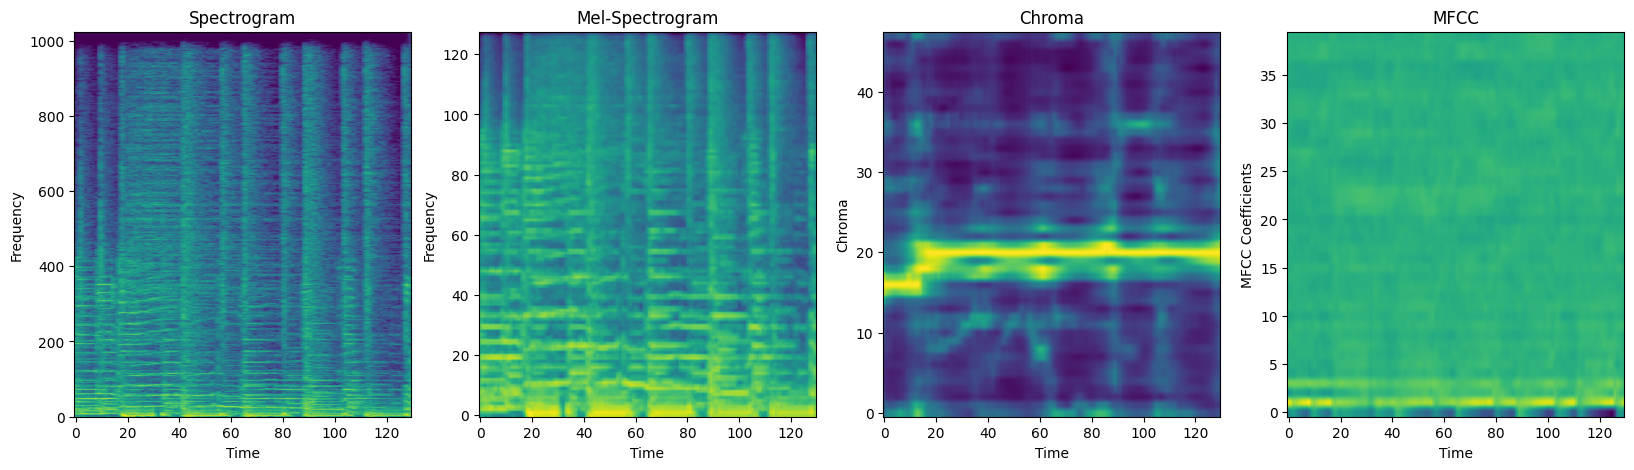

In [ ]:
# plot the spectrogram, mel-spectrogram, chroma, and mfcc in a 1x4 grid
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].set_title("Spectrogram")
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Time")
axs[0].imshow(librosa.amplitude_to_db(np.abs(librosa.stft(sound)), ref=np.max), aspect="auto", origin="lower")
axs[1].set_title("Mel-Spectrogram")
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Time")
axs[1].imshow(librosa.power_to_db(librosa.feature.melspectrogram(y=sound, sr=sr), ref=np.max), aspect="auto", origin="lower")
axs[2].set_title("Chroma")
axs[2].set_ylabel("Chroma")
axs[2].set_xlabel("Time")
axs[2].imshow(librosa.feature.chroma_cqt(y=sound, sr=sr, n_chroma=48, bins_per_octave=48), aspect="auto", origin="lower")
axs[3].set_title("MFCC")
axs[3].set_ylabel("MFCC Coefficients")
axs[3].set_xlabel("Time")
axs[3].imshow(librosa.feature.mfcc(y=sound, sr=sr, n_mfcc=40), aspect="auto", origin="lower")

plt.show()

Now let's pass the sample through the model. Convienantly we have a `TestHandler` class that has a `dataloader` object for each of the features we extract from the 3 second sound clips. Our example above should be the first sample of each dataloader, since the order is unshuffled

In [ ]:
import torch

test_handler = TestHandler(batch_size=1, num_workers=1)
# make each dataloader only contain the first sample
test_handler.spec_test_loader = torch.utils.data.DataLoader([test_handler.spec_test_loader.dataset[0]])
test_handler.mel_test_loader = torch.utils.data.DataLoader([test_handler.mel_test_loader.dataset[0]])
test_handler.chroma_test_loader = torch.utils.data.DataLoader([test_handler.chroma_test_loader.dataset[0]])
test_handler.mfcc_test_loader = torch.utils.data.DataLoader([test_handler.mfcc_test_loader.dataset[0]])


In [ ]:
import ensemble

weak_learners=ensemble.get_weak_learners()
print("Test Accuracy:", full_model([test_handler.spec_test_loader,test_handler.mfcc_test_loader,test_handler.chroma_test_loader,test_handler.mel_test_loader], weak_learners=[weak_learners[x] for x in [0,1,2,3]], cuda=False, verbose=True))

Model: Spectrogram
Predicted: pop
Actual: blues

Model: MFCC
Predicted: country
Actual: blues

Model: Chroma
Predicted: hiphop
Actual: blues

Model: Mel-Spectrogram
Predicted: country
Actual: blues

Majority vote:  country
Test Accuracy: 0.0


# Results

Below contains the qualitative and quantitative results.

In [9]:
from cnn.mfcc_training import test_model
from utils import plot
import ensemble
classes = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
weak_learners=ensemble.get_weak_learners()

test_handler = TestHandler(batch_size=1, num_workers=1)
models = ["spectrogram", "MFCC", "Chroma", "Mel-spectrogram"]
test_dataloader = [test_handler.spec_test_loader,test_handler.mfcc_test_loader,test_handler.chroma_test_loader,test_handler.mel_test_loader]

for i, model in enumerate(weak_learners):
    print(models[i])
    test_model(weak_learners[i], test_dataloader[i], save_confusion_matrix=True)
    plot.plot_confusion_matrix(model.name, classes)

spectrogram
Test Accuracy: 40.20%
MFCC
Test Accuracy: 36.20%
Chroma
Test Accuracy: 31.93%
Mel-spectrogram
Test Accuracy: 29.53%


# Ensemble Model
This code block implements ensemle learning for all of our best models

Note that the batch size in used in TestHandler should be divide the total number of samples evenly. This is why batch_size=1 is used

In [ ]:
from ensemble import ensemble

weak_learners=ensemble.get_weak_learners()
print("Test Accuracy:", ensemble.full_model([test_handler.spec_test_loader,test_handler.mfcc_test_loader,test_handler.chroma_test_loader,test_handler.mel_test_loader], weak_learners=[weak_learners[x] for x in [0,1,2,3]], cuda=True))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weight

Test Accuracy: 0.384


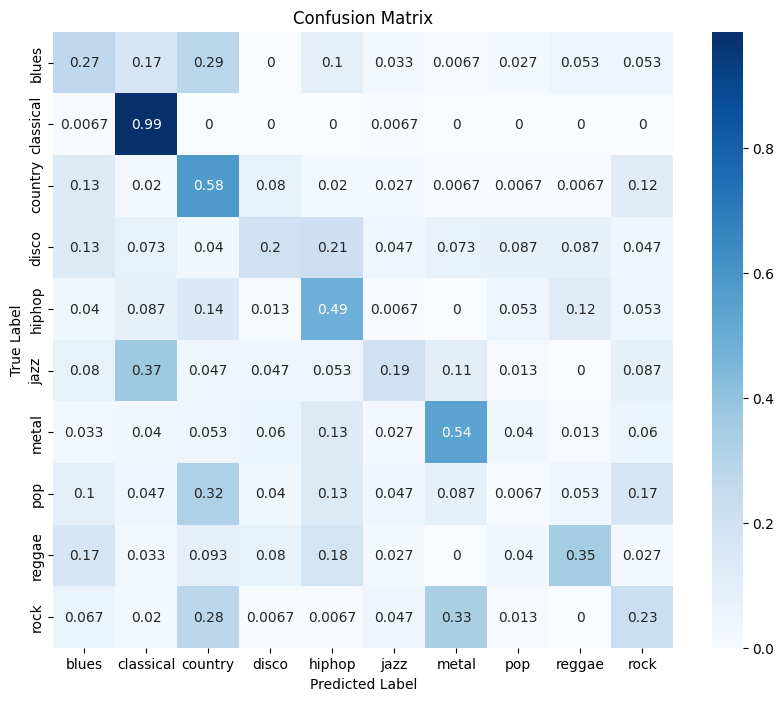

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

confusion_matrix = np.loadtxt("/content/Genrify/src/datasources/full_model_confusion_matirx.csv")
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from IPython.display import Audio, display

sound_file = "/content/Genrify/src/datasources/processed_test_data/0/0.wav_trimmed0.wav"
display(Audio(sound_file, autoplay=True))

In [ ]:
import utils
import librosa
from torchvision.datasets import DatasetFolder

data_dir = "/content/Genrify/src/datasources/processed_test_data"
full_dataset=DatasetFolder(data_dir, librosa.load, extensions=[".wav"])
print(dir(full_dataset))
print(full_dataset.classes)
print(full_dataset[0])

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_format_transform_repr', '_is_protocol', '_repr_indent', 'class_to_idx', 'classes', 'extensions', 'extra_repr', 'find_classes', 'loader', 'make_dataset', 'root', 'samples', 'target_transform', 'targets', 'transform', 'transforms']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
((array([-0.02843916, -0.02646531,  0.01190883, ..., -0.21578112,
       -0.19497617, -0.1976467 ], dtype=float32), 22050), 0)


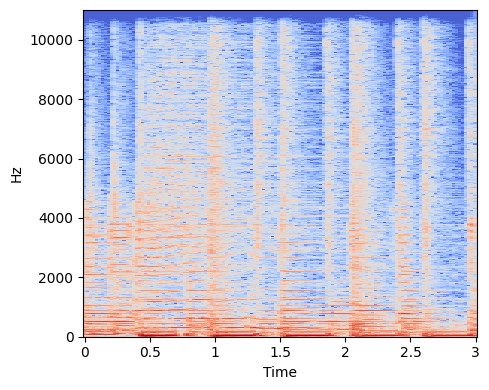

In [ ]:
sound, label = full_dataset[0]
spectrogram = utils.spectrogram.extract_features_spectrogram(sound)
plt.figure(figsize=(5, 4), frameon=False)
plt.ylim(0, 11000) # Always plot up to 11kHz
librosa.display.specshow(spectrogram, x_axis='time', y_axis='hz', vmin=-40, vmax=40) # Always show magnitude from -40 to +40 dB
plt.tight_layout()
plt.show()

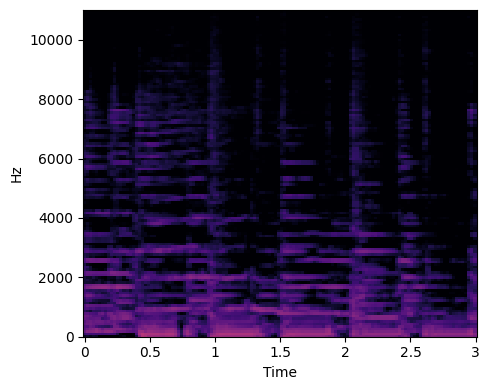

In [ ]:
mel = utils.mel_spectrogram.extract_features_mel_spectrogram(sound)
plt.figure(figsize=(5, 4), frameon=False)
plt.ylim(0, 11000) # Always plot up to 11kHz
librosa.display.specshow(mel, x_axis='time', y_axis='hz', vmin=-40, vmax=40) # Always show magnitude from -40 to +40 dB
plt.tight_layout()
plt.show()

In [ ]:
sound_array, sr = sound
display(Audio(sound_array, rate=sr, autoplay=False))

## Example to training an model

In [ ]:
# # training example
# mfcc_data_dir = os.path.join("Genrify", "src", "datasources", "mfcc")
# mfcc_data_handler = DataHandler(mfcc_data_dir, batch_size=32, num_workers=4)
# lr = 1e-4
# num_epochs = 30
# mfcc_cnn = mfcc_model.MFCC_CNN()
# print(f"Learning rate: {1e-4}")
# training.train(mfcc_cnn, mfcc_data_handler.train_loader, mfcc_data_handler.val_loader, num_epochs, lr, 32)
# model_path = training.get_model_name(mfcc_cnn.name, 32, lr, num_epochs-1)

# # plot in the notebook
# %matplotlib inline
# plot.plot_training_curve(model_path)
# plot.plot_confusion_matrix(model_path, range(10))

## Training Chroma

In [ ]:
# training example for chroma
#from cnn import chroma_model, training_chroma

#chroma_data_dir = '/content/Genrify/src/datasources/chroma'
#chroma_data_handler = DataHandler(chroma_data_dir, batch_size=32, num_workers=2)
#lr = 1e-4
#num_epochs = 60
#chroma_cnn = chroma_model.ChromaClassifier()
#print(f"Learning rate: {lr}")

#training_chroma.train(chroma_cnn, chroma_data_handler.train_loader, chroma_data_handler.val_loader, num_epochs, lr, 32, 10, 0.1)
#model_path = training.get_model_name(chroma_cnn.name, 32, lr, num_epochs-1)
# %matplotlib inline
# plot.plot_training_curve(model_path)
# plot.plot_confusion_matrix(model_path, range(10))

In [ ]:
import torch

def full_model(test_loaders, weak_learners=None, cuda=True, plot_dir="/content/Genrify/src/datasources", verbose=False):
    classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    models = ['Spectrogram', 'MFCC', 'Chroma', 'Mel-Spectrogram']
    if weak_learners is None:
        weak_learners = get_weak_learners()

    device = torch.device("cuda" if (torch.cuda.is_available() and cuda) else "cpu")

    for model in weak_learners:
        model.to(device)
        model.eval()

    correct = 0
    total = 0
    confusion_matrix = torch.zeros(10,10)

    with torch.no_grad():

        all_predictions = []
        all_labels = []
        for weak_learner_i, test_loader in enumerate(test_loaders):

            model_predictions = []
            model_labels = []
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Models have the same labels; no need to track each model's labels
                if weak_learner_i == 0:
                    model_labels.append(labels)

                outputs = weak_learners[weak_learner_i](inputs)
                _, predictions = torch.max(outputs.data, dim=1)
                model_predictions.append(predictions)

                if verbose:
                    print(f"Model: {models[weak_learner_i]}")
                    print(f"Predicted: {classes[predictions[0]]}")
                    print(f"Actual: {classes[labels[0]]}")
                    print()

            # Same reason as above
            if weak_learner_i == 0:
                stacked_labels = torch.stack(model_labels, dim=1)
                all_labels.append(stacked_labels)

            stacked_model_predictions = torch.stack(model_predictions, dim=1)
            all_predictions.append(stacked_model_predictions)

        stacked_all_predictions = torch.stack(all_predictions, dim=2)
        majority_vote = torch.mode(stacked_all_predictions, dim=2).values

        if verbose:
            print("Majority vote: ", classes[majority_vote.item()])

        for t, p in zip(all_labels[0].view(-1), majority_vote.view(-1)):
            confusion_matrix[t, p] += 1
        confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)[:, np.newaxis]
        np.savetxt(f"{plot_dir}/full_model_confusion_matirx.csv", confusion_matrix.numpy())

        correct_predictions = majority_vote == all_labels[0]

        correct = torch.sum(correct_predictions).item()
        total = all_labels[0].numel()

    accuracy = correct / float(total)
    return accuracy